In [1]:
!pip install datasets

In [2]:
%pip install pyspark

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, when
from statistics import mode as _mode
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
from pyspark.ml.classification import RandomForestClassificationModel
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.appName("Fraud-Detection").getOrCreate()

In [5]:
from pyspark.sql import SparkSession
from datasets import load_dataset

spark = SparkSession.builder.appName("Fraud-Detection").getOrCreate()

dataset = load_dataset("dazzle-nu/CIS435-CreditCardFraudDetection", split="train")
df_pd = dataset.to_pandas()

df_spark = spark.createDataFrame(df_pd)

df_spark.printSchema()
df_spark.show(5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


root
 |-- Unnamed: 0: long (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: double (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: long (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: long (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: long (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: long (nullable = true)
 |-- Unnamed: 23: double (nullable = true)
 |-- 6006: double (nullable = true)

+----------+---------------------+

In [6]:
print("Total Rows:", df_spark.count())
print("Columns:", df_spark.columns)

Total Rows: 1048575
Columns: ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'Unnamed: 23', '6006']


In [7]:
from pyspark.sql.functions import col, count, when, isnan

null_counts = [
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    for c in df_spark.columns
]

df_spark.select(null_counts).show()

+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-----------+-------+
|Unnamed: 0|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|Unnamed: 23|   6006|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-----------+-------+
|         0|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|    1048575|1048575|
+----------+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-----------+-------+


In [8]:
from pyspark.sql.functions import col

df_spark.groupBy("is_fraud").count().orderBy("count", ascending=False).show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1042569|
|       1|   6006|
+--------+-------+



In [9]:
total = df_spark.count()

df_spark.groupBy("is_fraud").count() \
    .withColumn("percentage", (col("count") / total) * 100) \
    .orderBy("count", ascending=False) \
    .show()

+--------+-------+------------------+
|is_fraud|  count|        percentage|
+--------+-------+------------------+
|       0|1042569| 99.42722265932336|
|       1|   6006|0.5727773406766326|
+--------+-------+------------------+



**Class Distribution (Fraud vs Normal)**

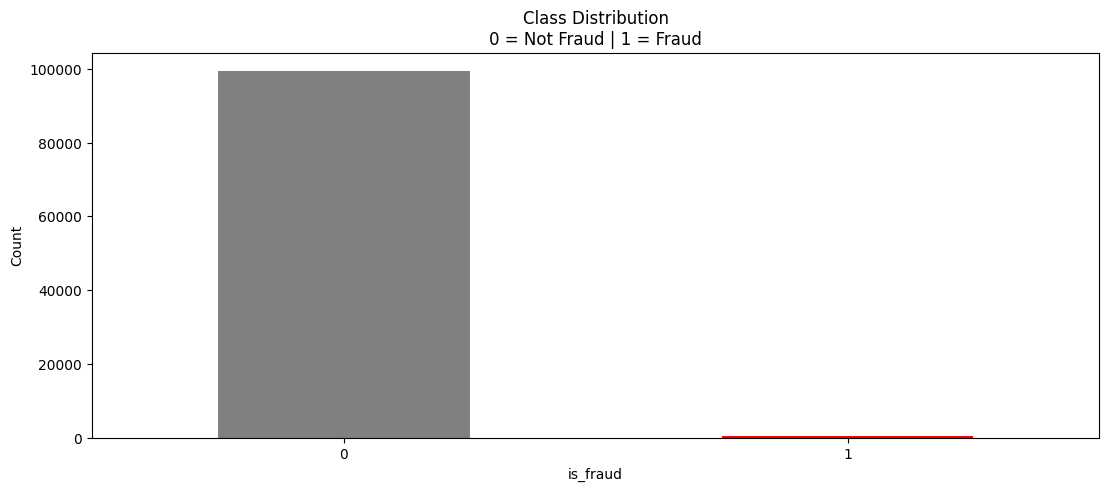

In [12]:
import matplotlib.pyplot as plt
df_pandas = df_spark.toPandas()

# Plot Fraud vs Normal distribution
df_pandas['is_fraud'].value_counts().plot.bar(
    title="Class Distribution\n0 = Not Fraud | 1 = Fraud",
    color=['grey', 'red'],
    rot=0,
    figsize=(13, 5)
)
plt.xlabel("is_fraud")
plt.ylabel("Count")
plt.show()

**Transaction Amount Distribution**

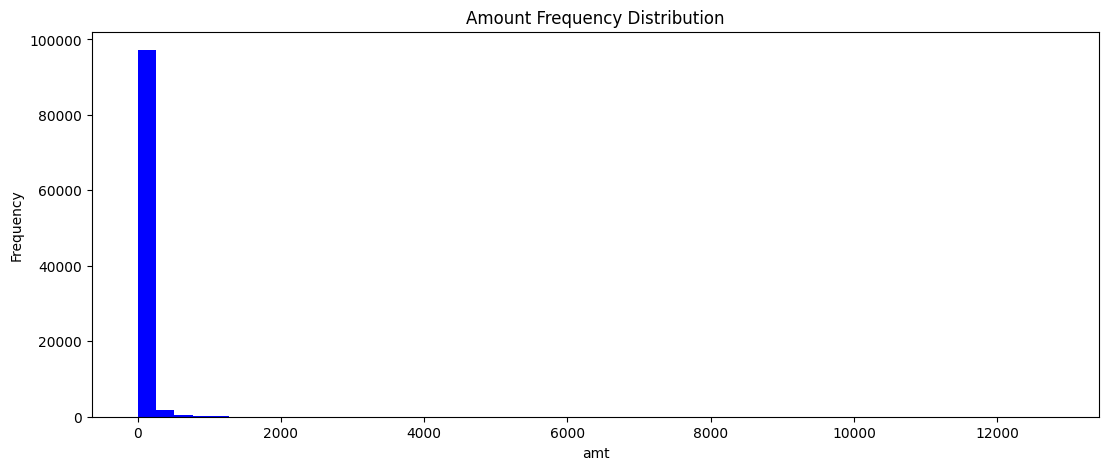

In [13]:
# Plot Amount Frequency Histogram
df_pandas['amt'].plot.hist(
    title="Amount Frequency Distribution",
    bins=50,
    color='blue',
    figsize=(13, 5)
)
plt.xlabel("amt")
plt.ylabel("Frequency")
plt.show()

**All Feature Distributions (excluding amount & class)**

In [16]:
print(df_pandas.columns.tolist())

['_0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', '_23', '_24']


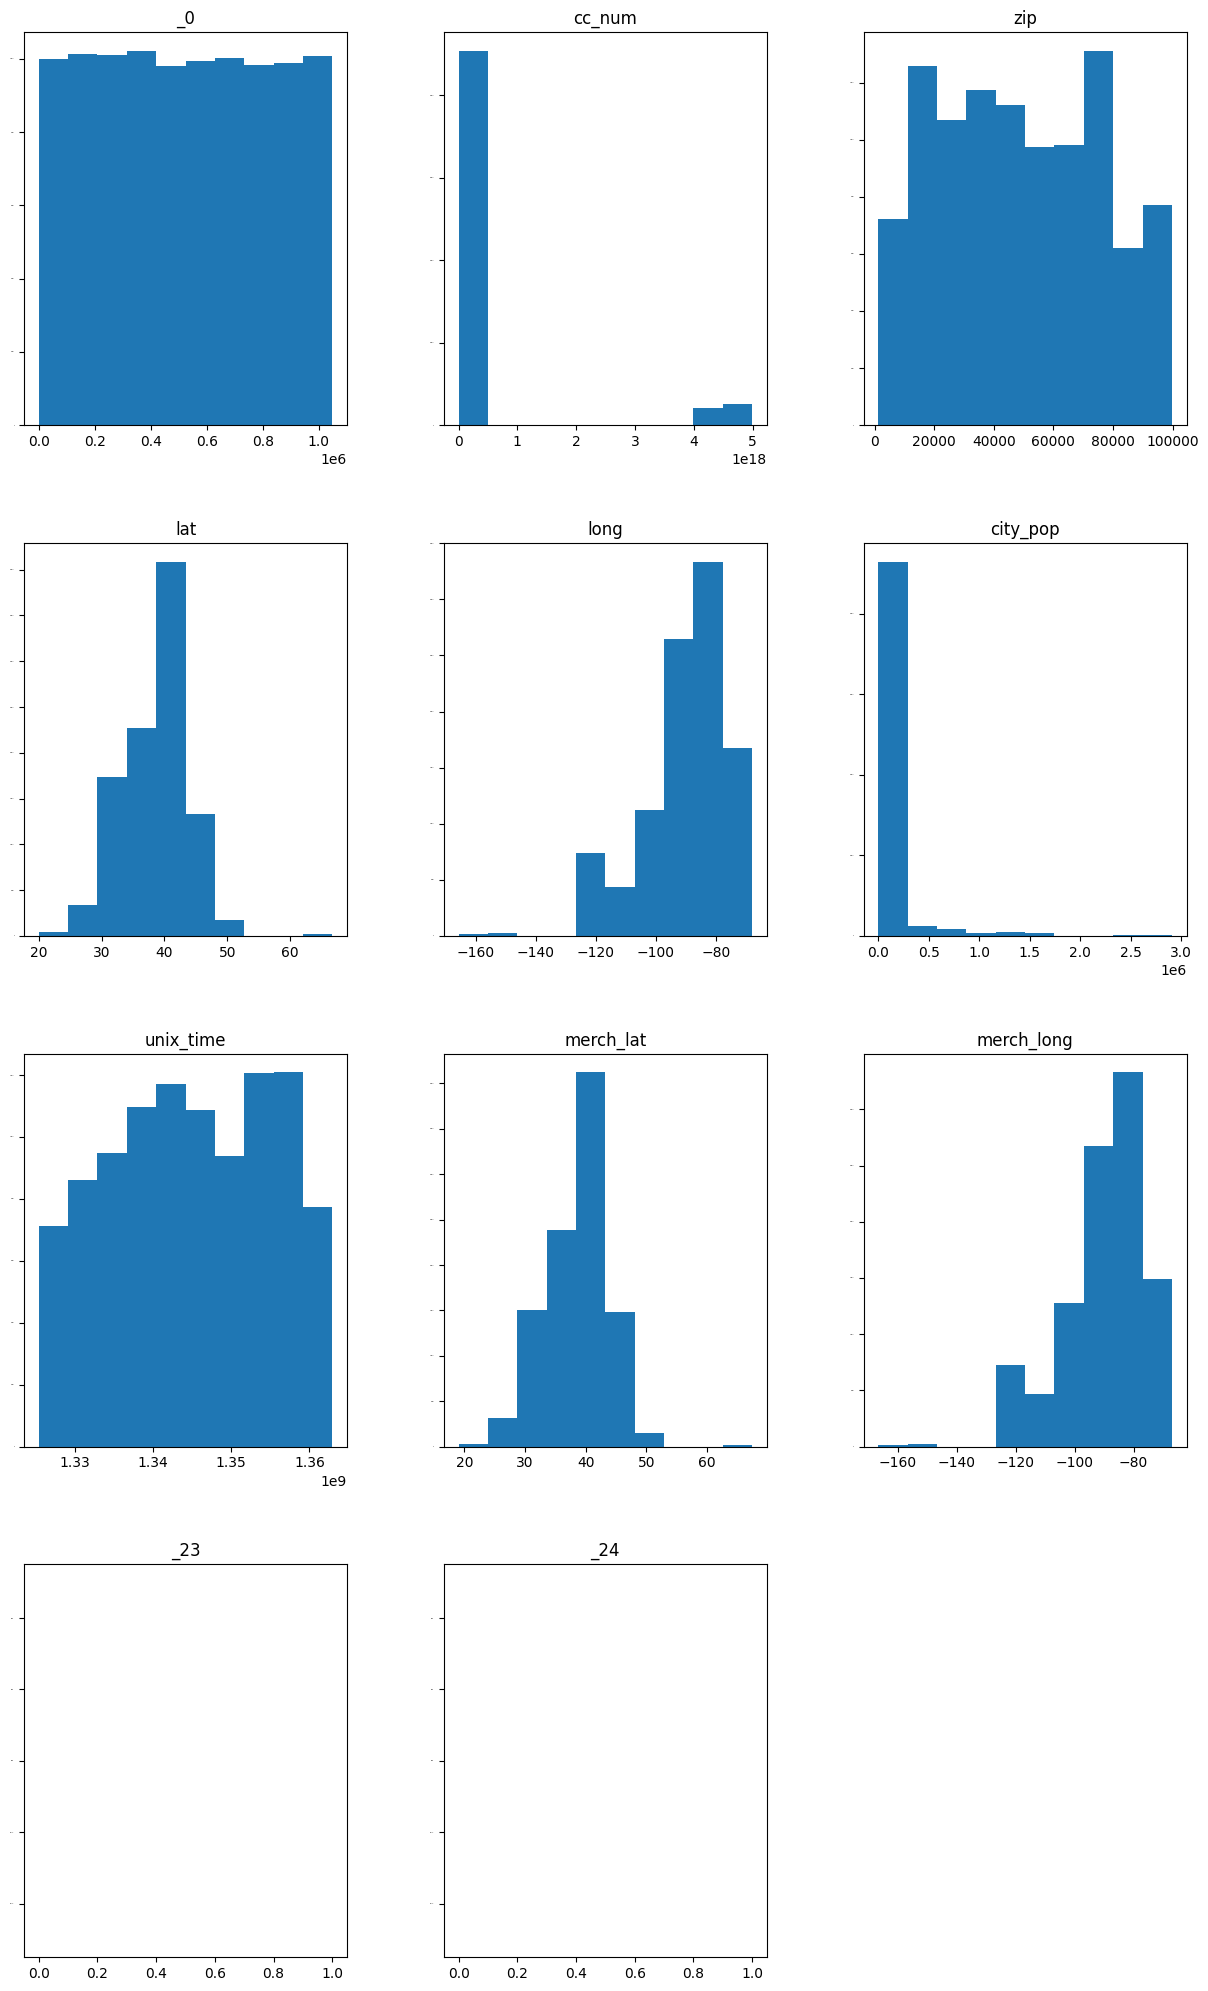

In [17]:
df_pandas.drop(['amt', 'is_fraud'], axis=1).hist(
    figsize=(15, 25),
    ylabelsize=False,
    grid=False
)
plt.show()

In [19]:
columns_to_keep = [
    'trans_date_trans_time', 'merchant', 'category', 'amt',
    'gender', 'city', 'state', 'zip', 'lat', 'long',
    'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long',
    'is_fraud'
]
df_model = df_pandas[columns_to_keep].copy()

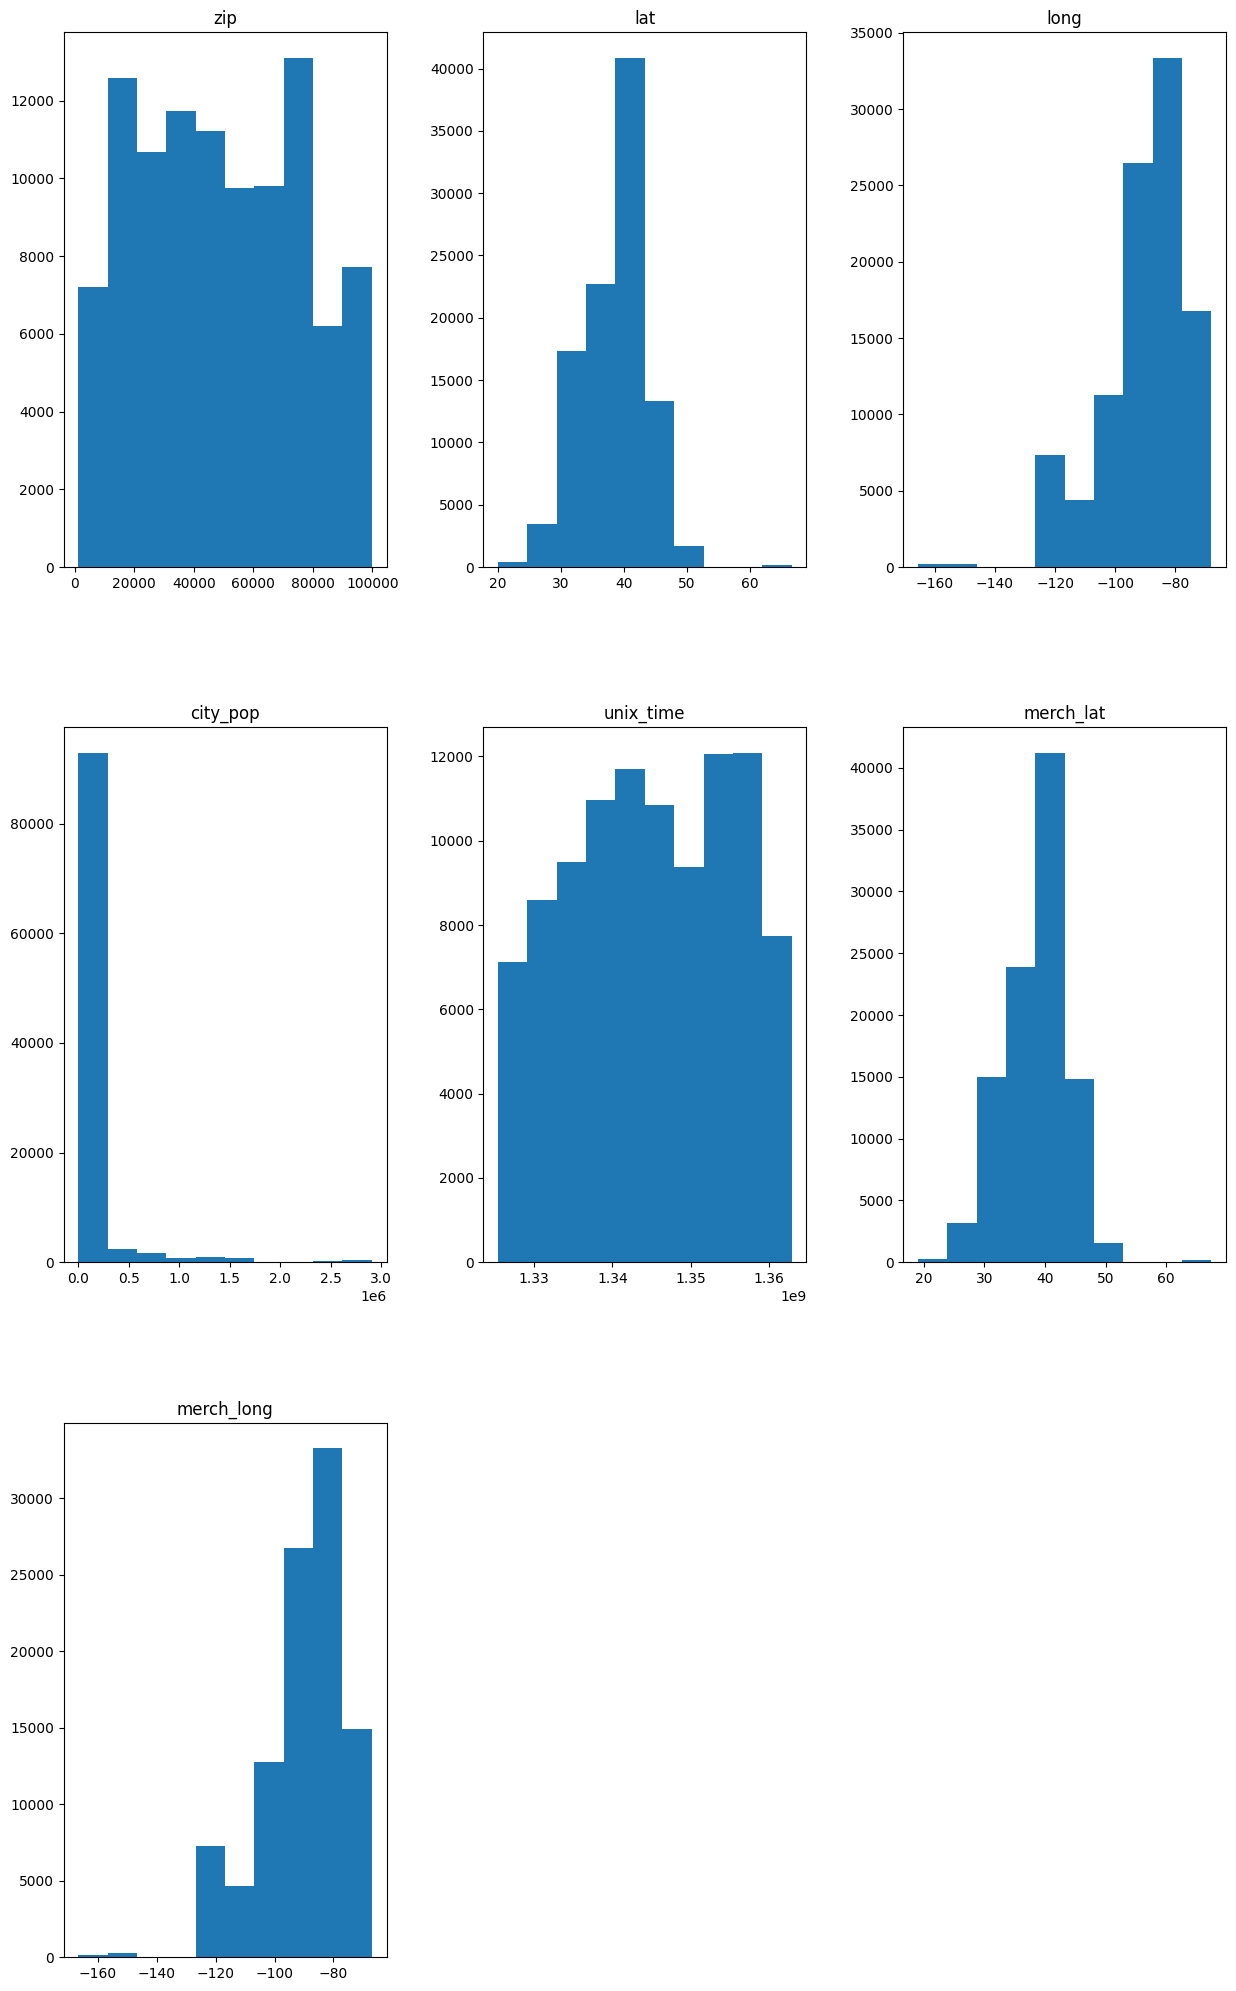

In [20]:
numeric_df = df_cleaned.select_dtypes(include='number')
numeric_df.drop(['amt', 'is_fraud'], axis=1).hist(
    figsize=(15, 25),
    grid=False
)
plt.show()

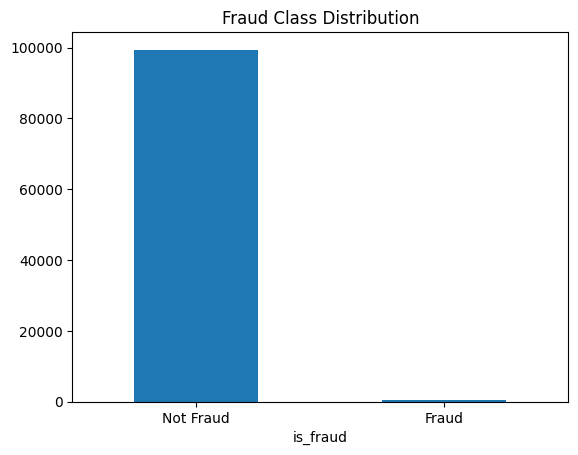

In [21]:
df_pandas['is_fraud'].value_counts().plot(kind='bar', title='Fraud Class Distribution')
plt.xticks(ticks=[0,1], labels=['Not Fraud', 'Fraud'], rotation=0)
plt.show()

**Feature Engineering**

In [22]:
import pandas as pd
df_model['trans_date_trans_time'] = pd.to_datetime(df_model['trans_date_trans_time'])

df_model['hour'] = df_model['trans_date_trans_time'].dt.hour
df_model['day'] = df_model['trans_date_trans_time'].dt.day
df_model['weekday'] = df_model['trans_date_trans_time'].dt.weekday
df_model['month'] = df_model['trans_date_trans_time'].dt.month
df_model.drop(columns=['trans_date_trans_time'], inplace=True)
print(df_model.shape)
df_model.head()

<ipython-input-22-709e084d311b>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model['trans_date_trans_time'] = pd.to_datetime(df_model['trans_date_trans_time'])


(100000, 19)


,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day,weekday,month
0,fraud_Donnelly LLC,entertainment,65.93,M,Lahoma,OK,73754,36.3850,-98.0727,1078,Podiatrist,1354296218,35.465398,-98.819133,0,17,30,5,11
1,fraud_Dibbert-Green,entertainment,61.72,F,Smiths Grove,KY,42171,37.0581,-86.1938,6841,"Therapist, sports",1357666563,37.496662,-86.764345,0,17,8,2,1
2,"fraud_O'Reilly, Mohr and Purdy",home,81.11,M,Smithfield,IL,61477,40.4855,-90.2856,631,Futures trader,1356716895,40.039452,-90.699215,0,17,28,5,12
3,"fraud_Johnston, Nikolaus and Maggio",grocery_net,73.17,M,Corriganville,MD,21524,39.6967,-78.8031,626,Energy engineer,1354334696,39.392946,-78.156633,0,4,1,6,12
4,fraud_Fisher Inc,shopping_net,5.50,M,Cuyahoga Falls,OH,44223,41.1464,-81.5107,47772,Equities trader,1349769383,40.364708,-82.388244,0,7,9,2,10


**Categorical Encoder**

In [23]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le

df_model.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day,weekday,month
0,139,0,65.93,1,402,36,73754,36.3850,-98.0727,1078,338,1354296218,35.465398,-98.819133,0,17,30,5,11
1,134,0,61.72,0,723,17,42171,37.0581,-86.1938,6841,463,1357666563,37.496662,-86.764345,0,17,8,2,1
2,461,6,81.11,1,722,14,61477,40.4855,-90.2856,631,202,1356716895,40.039452,-90.699215,0,17,28,5,12
3,291,3,73.17,1,164,20,21524,39.6967,-78.8031,626,148,1354334696,39.392946,-78.156633,0,4,1,6,12
4,174,11,5.50,1,180,35,44223,41.1464,-81.5107,47772,179,1349769383,40.364708,-82.388244,0,7,9,2,10


** Convert all categorical columns to numeric first using LabelEncoder + SMOTE**

In [27]:
from sklearn.utils import resample
df_majority = df_model[df_model['is_fraud'] == 0]
df_minority = df_model[df_model['is_fraud'] == 1]
target_pct = 0.1066
target_total = int(len(df_majority) / (1 - target_pct))
target_fraud_count = target_total - len(df_majority)

print(f"Target fraud count to reach {target_pct*100:.2f}%: {target_fraud_count}")

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=target_fraud_count,
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['is_fraud'].value_counts(normalize=True))
print("Final shape:", df_balanced.shape)

Target fraud count to reach 10.66%: 11865
is_fraud
0    0.8934
1    0.1066
Name: proportion, dtype: float64
Final shape: (111304, 19)


**Train-Test Split + Scaling**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_balanced.drop('is_fraud', axis=1)
y = df_balanced['is_fraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (77912, 18) | Test shape: (33392, 18)


In [31]:
# Convert Pandas DataFrame to Spark DataFrame
df = spark.createDataFrame(df_balanced)

In [32]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

feature_cols = [col for col in df.columns if col != 'is_fraud']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="scaled_features", numTrees=100)
pipeline = Pipeline(stages=[assembler, scaler, rf])
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)
model = pipeline.fit(train_df)

predictions = model.transform(test_df)
predictions.select("is_fraud", "prediction", "probability").show(5)

+--------+----------+--------------------+
|is_fraud|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.90415449534582...|
|       0|       0.0|[0.97166745534629...|
|       0|       0.0|[0.96989634857754...|
|       0|       0.0|[0.96872925447574...|
|       0|       0.0|[0.97094528538532...|
+--------+----------+--------------------+
only showing top 5 rows



**Evaluation (Spark ML Metrics)**

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

print(f"📊 Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall:    {recall:.4f}")
print(f"🏆 F1 Score:  {f1_score:.4f}")

📊 Accuracy:  0.9579
🎯 Precision: 0.9564
🔁 Recall:    0.9579
🏆 F1 Score:  0.9553


**Confusion Matrix in PySpark**

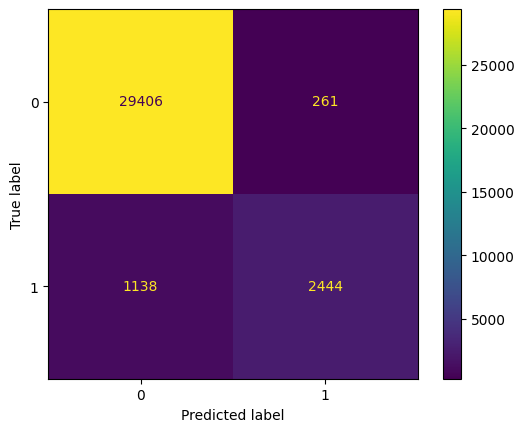

In [34]:
from pyspark.sql.functions import col
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = predictions.select("is_fraud").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**ROC AUC Curve (Binary Classification)**

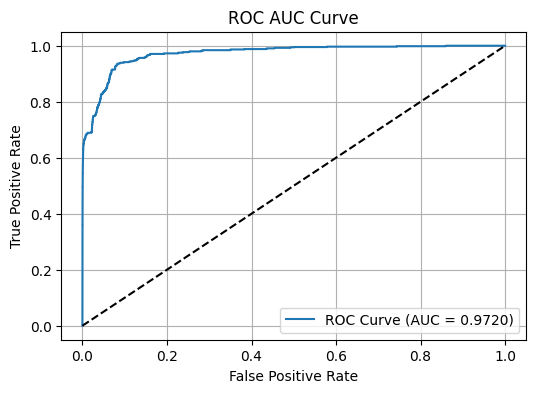

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
prob_positive = predictions.select("probability").rdd.map(lambda row: row['probability'][1]).collect()
true_labels = predictions.select("is_fraud").rdd.map(lambda row: row["is_fraud"]).collect()
fpr, tpr, _ = roc_curve(true_labels, prob_positive)
roc_auc = roc_auc_score(true_labels, prob_positive)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend()
plt.grid(True)
plt.show()

**Logistic Regression**

In [36]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="is_fraud", featuresCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

Decision Tree for logistic regression

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler, dt])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

**Gradient-Boosted Trees (GBT)**

In [38]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="is_fraud", featuresCol="scaled_features", maxIter=50)
pipeline = Pipeline(stages=[assembler, scaler, gbt])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

**🚫 Note: GBT doesn't support classification with more than 2 classes. We're good since it's binary.**

**Multilayer Perceptron (Neural Network)**

In [39]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [len(feature_cols), 20, 10, 2]
mlp = MultilayerPerceptronClassifier(layers=layers, labelCol="is_fraud", featuresCol="scaled_features", maxIter=100)

pipeline = Pipeline(stages=[assembler, scaler, mlp])
model = pipeline.fit(train_df)
predictions = model.transform(test_df)

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)

AUC: 0.8439737667299291


**Logistic Regression**

In [46]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="scaled_features", numTrees=100)
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

In [44]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier

# Logistic Regression
lr = LogisticRegression(labelCol="is_fraud", featuresCol="scaled_features")
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
lr_model = lr_pipeline.fit(train_df)

# Decision Tree
dt = DecisionTreeClassifier(labelCol="is_fraud", featuresCol="scaled_features")
dt_pipeline = Pipeline(stages=[assembler, scaler, dt])
dt_model = dt_pipeline.fit(train_df)

# GBT
gbt = GBTClassifier(labelCol="is_fraud", featuresCol="scaled_features", maxIter=50)
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt])
gbt_model = gbt_pipeline.fit(train_df)

# Multilayer Perceptron
layers = [len(feature_cols), 20, 10, 2]
mlp = MultilayerPerceptronClassifier(layers=layers, labelCol="is_fraud", featuresCol="scaled_features", maxIter=100)
mlp_pipeline = Pipeline(stages=[assembler, scaler, mlp])
mlp_model = mlp_pipeline.fit(train_df)

#RandomForstClassifier
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="scaled_features", numTrees=100)
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

model_preds = {
    "Logistic Regression": lr_model.transform(test_df),
    "Decision Tree": dt_model.transform(test_df),
    "Gradient Boosted Trees": gbt_model.transform(test_df),
    "Multilayer Perceptron": mlp_model.transform(test_df),
    "Random Forest": rf_model.transform(test_df)
}


evaluator_acc = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedRecall")
evaluator_auc = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

metrics = []
for name, pred in model_preds.items():
    acc = evaluator_acc.evaluate(pred)
    prec = evaluator_precision.evaluate(pred)
    rec = evaluator_recall.evaluate(pred)
    f1 = evaluator_f1.evaluate(pred)
    auc = evaluator_auc.evaluate(pred)

    metrics.append((name, acc, prec, rec, f1, auc))

    print(f"\n{name}:")
    print(f"   ✅ Accuracy :  {acc:.4f}")
    print(f"   🎯 Precision: {prec:.4f}")
    print(f"   🔁 Recall   : {rec:.4f}")
    print(f"   🏆 F1 Score : {f1:.4f}")
    print(f"   📈 AUC      : {auc:.4f}")

best_model = max(metrics, key=lambda x: x[4])
print(f"\n🔥 Best Model based on F1 Score: {best_model[0]} with F1 = {best_model[4]:.4f}")


Logistic Regression:
   ✅ Accuracy :  0.9377
   🎯 Precision: 0.9356
   🔁 Recall   : 0.9377
   🏆 F1 Score : 0.9289
   📈 AUC      : 0.8508

Decision Tree:
   ✅ Accuracy :  0.9706
   🎯 Precision: 0.9703
   🔁 Recall   : 0.9706
   🏆 F1 Score : 0.9704
   📈 AUC      : 0.9105

Gradient Boosted Trees:
   ✅ Accuracy :  0.9840
   🎯 Precision: 0.9838
   🔁 Recall   : 0.9840
   🏆 F1 Score : 0.9838
   📈 AUC      : 0.9961

Multilayer Perceptron:
   ✅ Accuracy :  0.9524
   🎯 Precision: 0.9499
   🔁 Recall   : 0.9524
   🏆 F1 Score : 0.9498
   📈 AUC      : 0.8440

Random Forest:
   ✅ Accuracy :  0.9579
   🎯 Precision: 0.9564
   🔁 Recall   : 0.9579
   🏆 F1 Score : 0.9553
   📈 AUC      : 0.9720

🔥 Best Model based on F1 Score: Gradient Boosted Trees with F1 = 0.9838


In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

models = [
    ("Logistic Regression", lr_model),
    ("Decision Tree", dt_model),
    ("Gradient Boosted Trees", gbt_model),
    ("Multilayer Perceptron", mlp_model),
    ("Random Forest", rf_model)
]

evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

auc_scores = {}

for name, model in models:
    preds = model.transform(test_df)
    auc = evaluator.evaluate(preds)
    auc_scores[name] = auc
    print(f"{name} - ROC AUC: {auc:.4f}")

Logistic Regression - ROC AUC: 0.8508
Decision Tree - ROC AUC: 0.9105
Gradient Boosted Trees - ROC AUC: 0.9961
Multilayer Perceptron - ROC AUC: 0.8440
Random Forest - ROC AUC: 0.9720


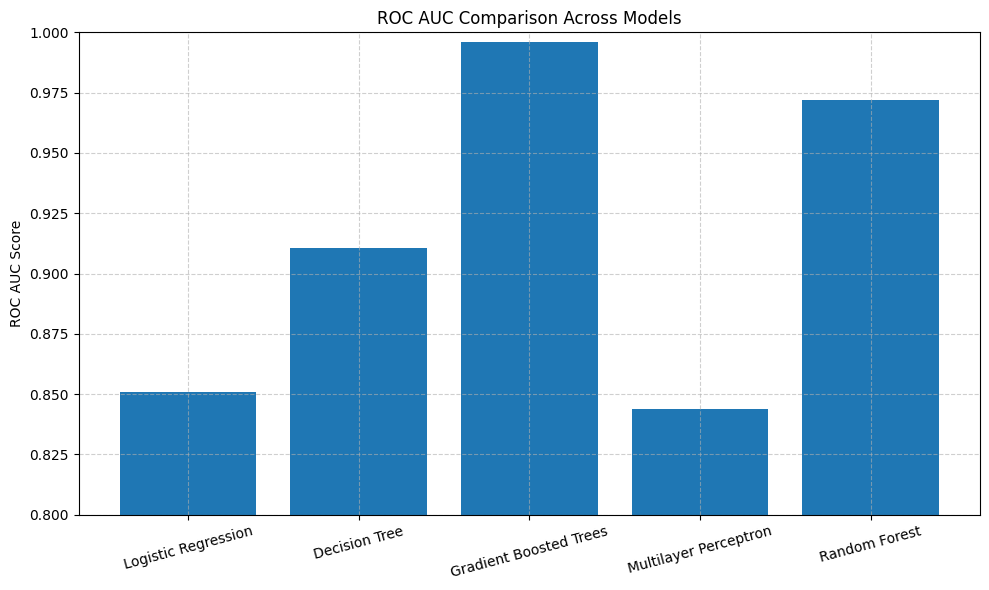

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(auc_scores.keys(), auc_scores.values())
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC Comparison Across Models")
plt.xticks(rotation=15)
plt.ylim(0.80, 1.00)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [51]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract ROC data
def get_roc_data(predictions, label_col="is_fraud", prob_col="probability"):
    # Extract probability of class 1
    pred_pd = predictions.select(prob_col, label_col).rdd \
                .map(lambda row: (float(row[0][1]), row[1])) \
                .toDF(["probability", "label"]).toPandas()

    fpr, tpr, _ = roc_curve(pred_pd['label'], pred_pd['probability'])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [52]:
models = {
    "Logistic Regression": lr_model.transform(test_df),
    "Decision Tree": dt_model.transform(test_df),
    "GBT": gbt_model.transform(test_df),
    "MLP": mlp_model.transform(test_df),
    "Random Forest": rf_model.transform(test_df)
}

roc_data = {}

for name, preds in models.items():
    fpr, tpr, roc_auc = get_roc_data(preds)
    roc_data[name] = (fpr, tpr, roc_auc)


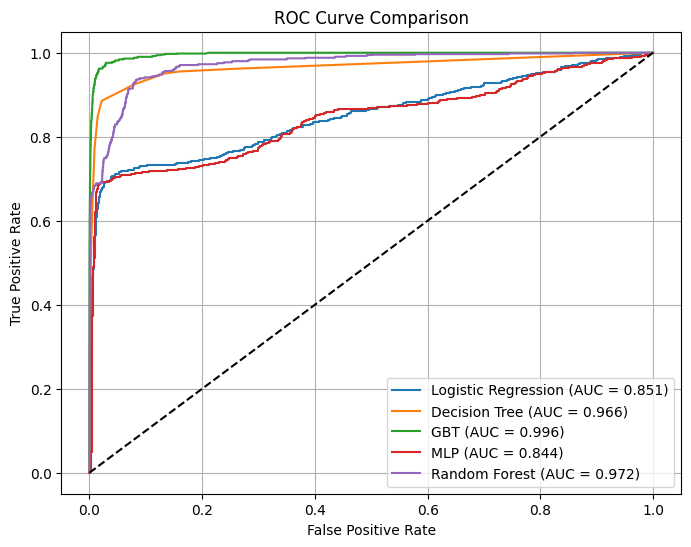

In [53]:
plt.figure(figsize=(8, 6))

for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [54]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

gbt = GBTClassifier(labelCol="is_fraud", featuresCol="scaled_features", maxIter=50)

pipeline = Pipeline(stages=[assembler, scaler, gbt])
pipeline_model = pipeline.fit(train_df)

pipeline_model.save("models/gbt_pipeline_model")